In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 260, color_map = 'RdPu', dpi_save = 260, vector_friendly = True, format = 'svg')

Running Scanpy 1.4.4.post1, on 2019-12-09 12:51.


Seeing how Carlos's running of scgen results in weird scrambled expression of the raw data, which I can't seem to figure out or fix, let's just do it all again from scratch to try to remove the ways in which things could have gone south along the way. To start, let's recreate the joint heart object, in ready to analyse form - 7000 genes, "Seurat-normalised" expression. This way it can be fed into scgen, but can also serve as the basis for bbknn.

To do so, we need to translate the original annotated leiden clustering. Let's do so.

### Convert objects to raw

- Sanger cells

In [3]:
sanger_cells = sc.read_h5ad('/home/jovyan/experiments/1-scGEN_data_integration/hca_heart_Cells_annotated_ml191209.h5ad')
sanger_cells_raw = anndata.AnnData(X = sanger_cells.raw.X , obs = sanger_cells.obs, var = sanger_cells.raw.var, obsm = sanger_cells.obsm)
sanger_cells_raw.shape

(45885, 33538)

- Sanger CD45+ cells

In [4]:
sanger_cd45 = sc.read_h5ad('/home/jovyan/experiments/1-scGEN_data_integration/hca_heart_CD45_annotated_ml191209.h5ad')
sanger_cd45_raw = anndata.AnnData(X = sanger_cd45.raw.X , obs = sanger_cd45.obs, var = sanger_cd45.raw.var, obsm = sanger_cd45.obsm)
sanger_cd45_raw.shape

(83089, 33538)

- Sanger Nuclei

In [5]:
sanger_nuclei = sc.read_h5ad('/home/jovyan/experiments/1-scGEN_data_integration/sanger_heart_NucSeq_annotated_ctl191209.h5ad')
sanger_nuclei_raw = anndata.AnnData(X = sanger_nuclei.raw.X , obs = sanger_nuclei.obs, var = sanger_nuclei.raw.var, obsm = sanger_nuclei.obsm)
sanger_nuclei_raw.shape

(188378, 33538)

- Harvard nuclei

In [6]:
harvard_nuclei = sc.read_h5ad('/home/jovyan/experiments/1-scGEN_data_integration/harvard_heart_NucSeq_annotated_ctl191209.h5ad')
harvard_nuclei_raw = anndata.AnnData(X = harvard_nuclei.raw.X , obs = harvard_nuclei.obs, var = harvard_nuclei.raw.var, obsm = harvard_nuclei.obsm)
harvard_nuclei_raw.shape

(181760, 33538)

The gene is where it's supposed to be, same for the clusters.

To translate, we'll create two lists - one with a set of clusters that need to be collapsed into a single cell type label, and then the other with said cell type label. In a perfect world, this would just be a dictionary, but we need to match a variable number of clusters to each label and this works just fine. We then loop over the two lists in unison, getting the cluster set and the new cell type label to replace it with available at once. So we replace one cluster at a time to get the labels in place.

In [7]:
sanger_cells_raw.obs['leiden_annotated'].cat.categories

Index(['EC0', 'EC1', 'PC2', 'SMC3', 'EC4', 'EC5', 'FB6', 'Myeloid7',
       'Lymphoid8', 'CMC9', 'EC10', 'Neuronal11'],
      dtype='object')

In [10]:
trans_from=[['CMC9'],['EC0','EC1','EC4','EC5','EC10'],['PC2'],['SMC3'],['FB6'],['Lymphoid8'],['Myeloid7'],['Neuronal11']]
trans_to = ['cmc', 'ec', 'pc', 'smc', 'fb', 'lymphoid', 'myeloid', 'neuronal']

sanger_cells_raw.obs['cell_type'] = [str(i) for i in sanger_cells_raw.obs['leiden_annotated']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        sanger_cells_raw.obs['cell_type'][sanger_cells_raw.obs['cell_type'] == leiden_from] = celltype

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


... storing 'cell_type' as categorical


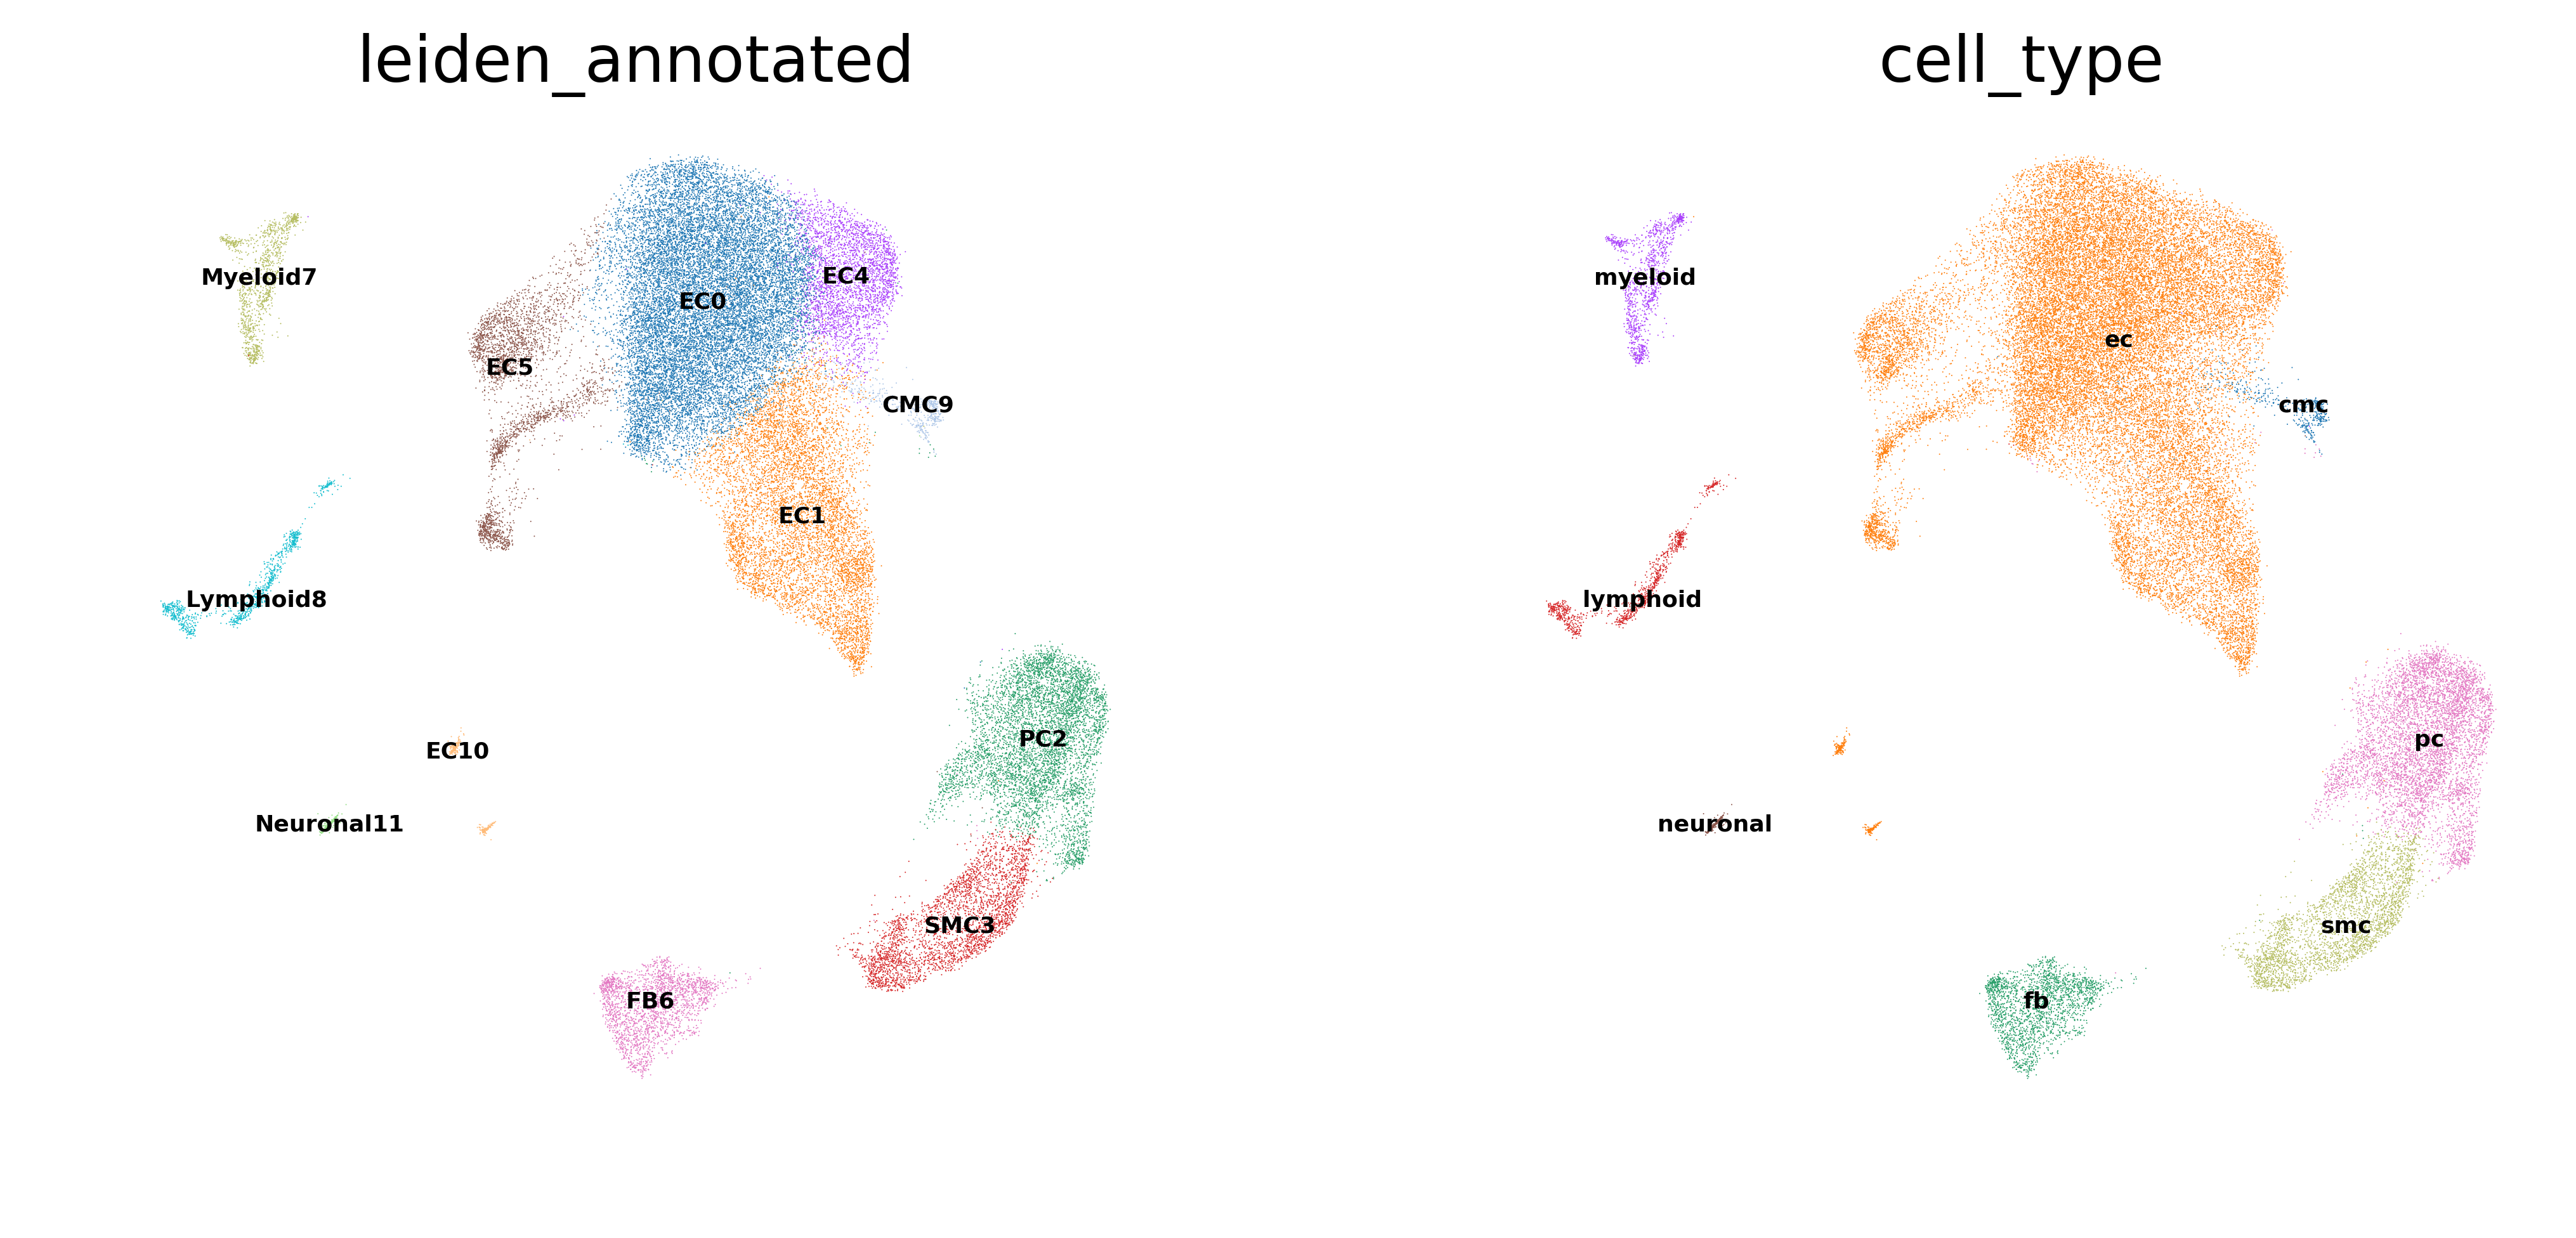

In [11]:
sc.pl.umap(sanger_cells_raw, color=['leiden_annotated','cell_type'], size = 0.3, legend_fontsize = 5, legend_loc = 'on data', frameon = False)

Translation successful. Continue procedure for remaining subsets of data.

In [12]:
harvard_nuclei_raw.obs['leiden_annotated'].cat.categories

Index(['PC0', 'CM1-V', 'CM2-V', 'FB3', 'CM4-V', 'CM5-V', 'EC6', 'CM7-A', 'PC8',
       'SMC9', 'FB10', 'Myeloid11', 'Lymphoid12', 'CM13-V', 'Neuro14',
       'Mast15', 'EC16', 'Adipo17', 'SMC18', 'Str19', 'Lymphoid20', 'Str21'],
      dtype='object')

In [13]:
trans_from = [['CM1-V','CM2-V','CM4-V','CM5-V','CM7-A','CM13-V'],['EC6','EC16'],['PC0','PC8'],['SMC9','SMC18'],['FB3','FB10'],['Lymphoid12','Lymphoid20'],['Myeloid11','Mast15'],['Adipo17'],['Neuro14'],['Str19','Str21']]
trans_to = ['cmc', 'ec', 'pc', 'smc', 'fb', 'lymphoid', 'myeloid', 'adipocytes', 'neuronal', 'stromal']

harvard_nuclei_raw.obs['cell_type'] = [str(i) for i in harvard_nuclei_raw.obs['leiden_annotated']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        harvard_nuclei_raw.obs['cell_type'][harvard_nuclei_raw.obs['cell_type'] == leiden_from] = celltype

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


... storing 'cell_type' as categorical


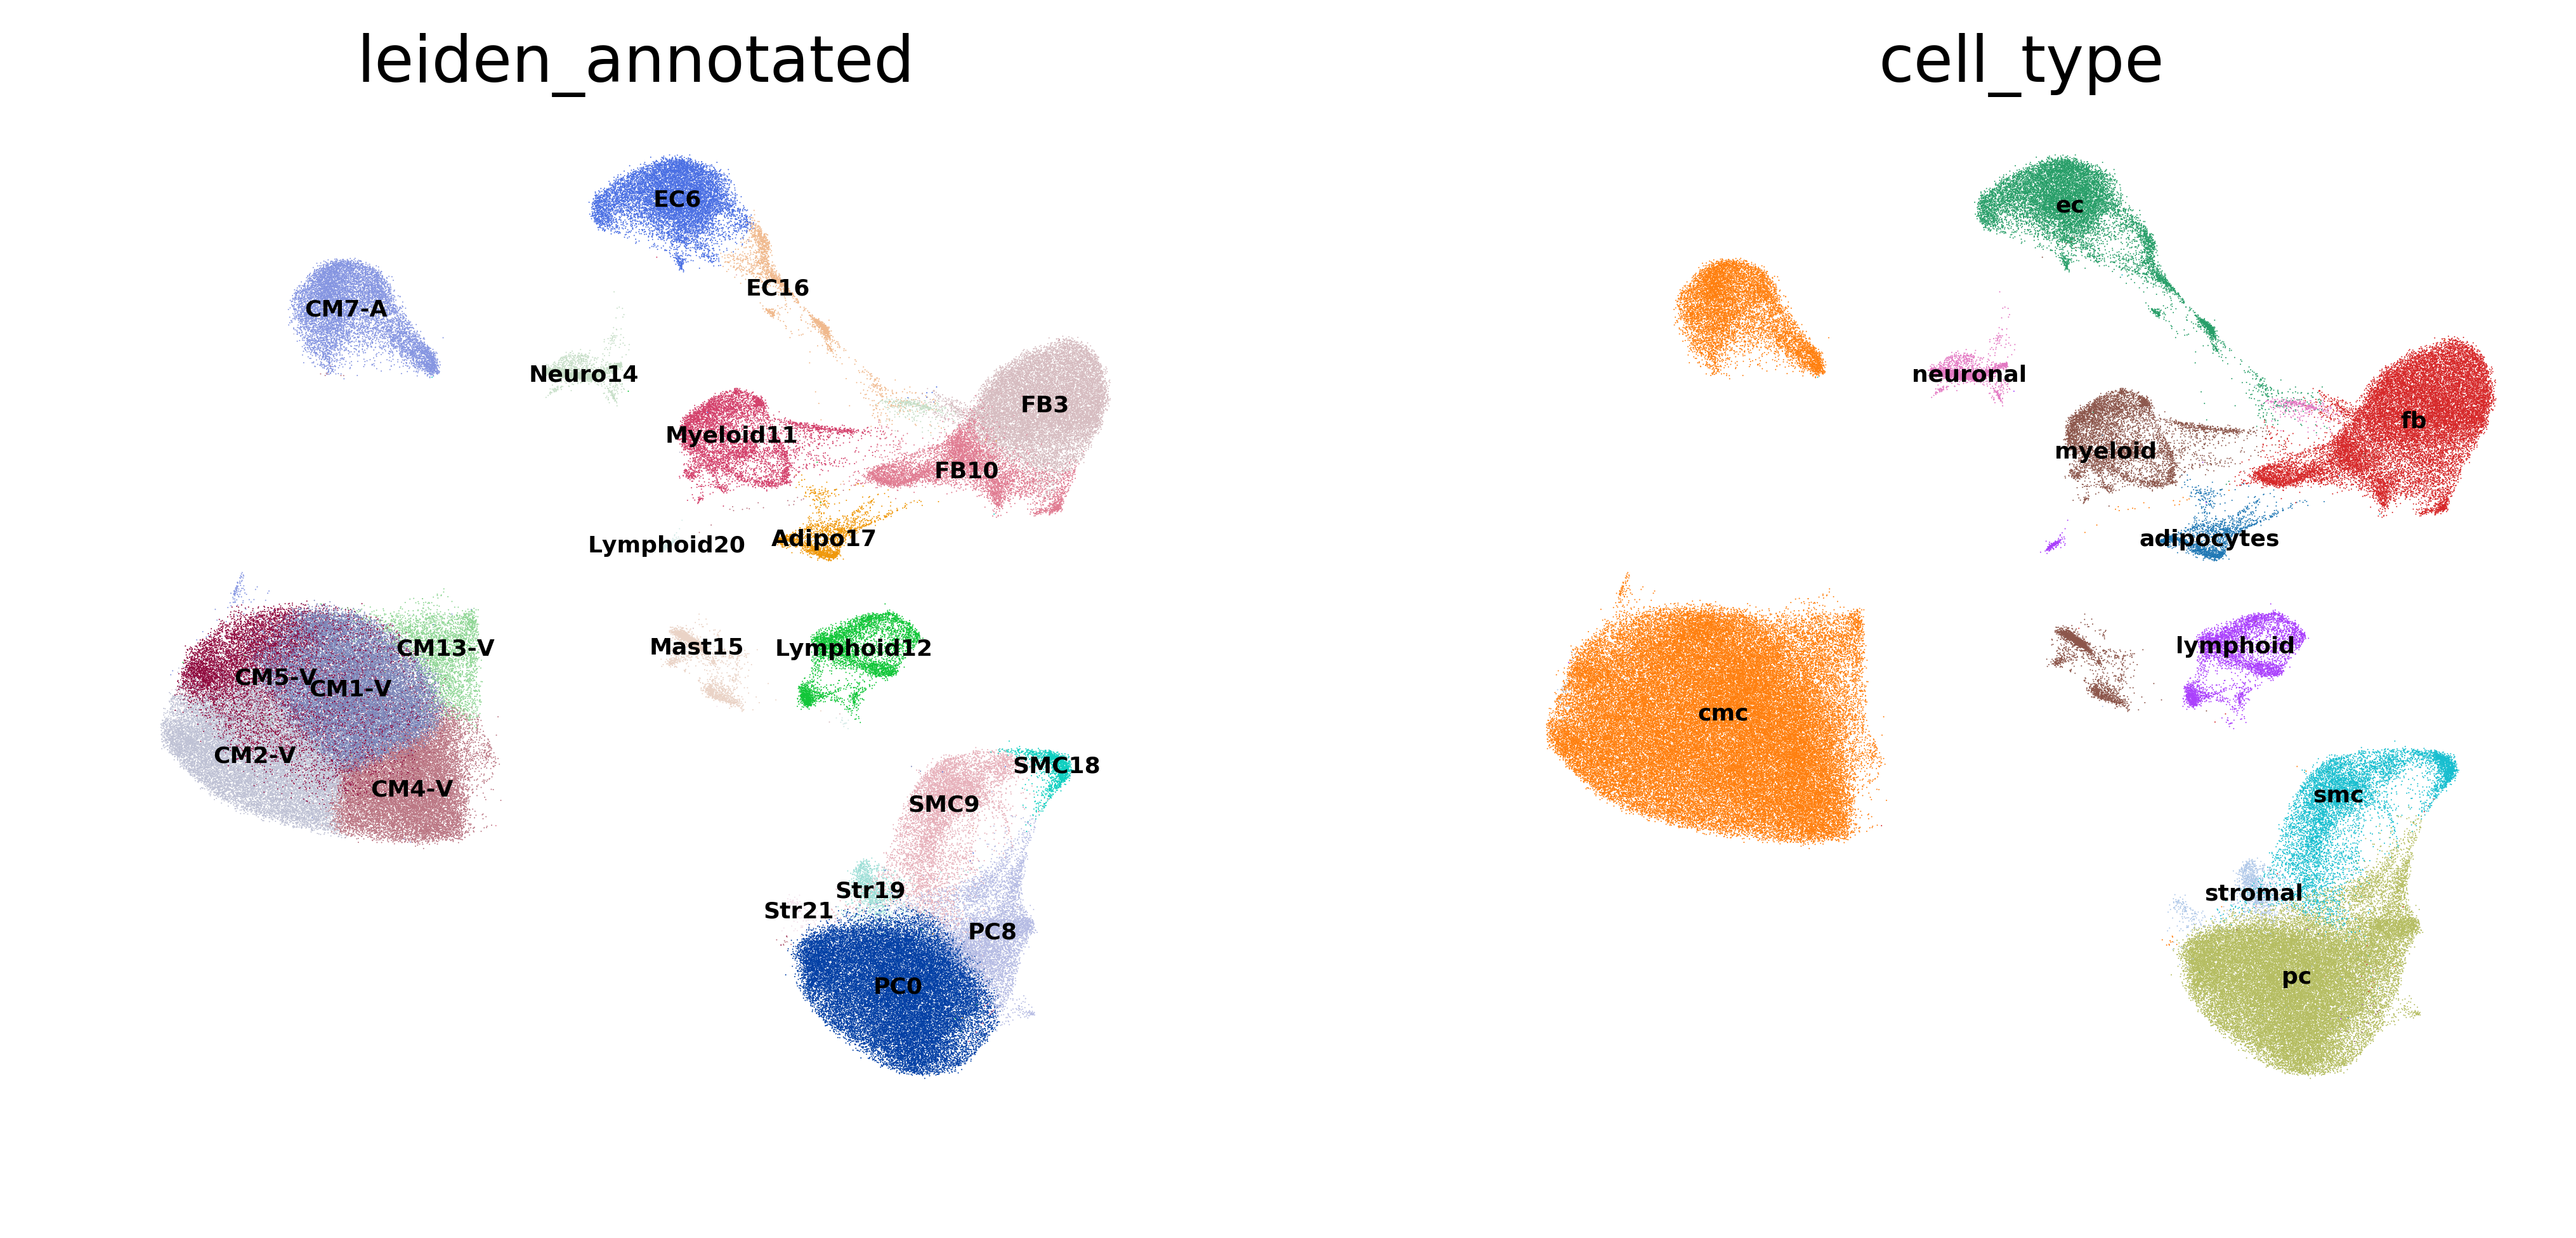

In [14]:
sc.pl.umap(harvard_nuclei_raw, color=['leiden_annotated','cell_type'], size = 0.3, legend_fontsize = 5, legend_loc = 'on data', frameon = False)

In [15]:
sanger_nuclei_raw.obs['leiden_annotated'].cat.categories

Index(['FB0', 'CM1-V', 'CM2-V', 'PC3', 'CM4-A', 'CM5-V', 'FB6', 'EC7', 'FB8',
       'Myeloid9', 'CM10-V', 'CM11-V', 'PC12', 'FB13', 'EC14', 'Lymphoid15',
       'CM16-V', 'Adipo17', 'Neuro18', 'SMC19', 'EC20', 'Str21', 'Mast22',
       'Str23'],
      dtype='object')

In [16]:
trans_from = [['CM1-V','CM2-V','CM4-A','CM5-V','CM10-V','CM11-V','CM16-V'],['EC7','EC14','EC20'],['PC3','PC12'], ['SMC19'],['FB0','FB6','FB8','FB13'],['Lymphoid15'],['Myeloid9','Mast22'],['Adipo17'],['Neuro18'],['Str21','Str23']]
trans_to = ['cmc', 'ec', 'pc', 'smc', 'fb', 'lymphoid', 'myeloid', 'adipocytes', 'neuronal', 'stromal']

sanger_nuclei_raw.obs['cell_type'] = [str(i) for i in sanger_nuclei_raw.obs['leiden_annotated']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        sanger_nuclei_raw.obs['cell_type'][sanger_nuclei_raw.obs['cell_type'] == leiden_from] = celltype

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


... storing 'cell_type' as categorical


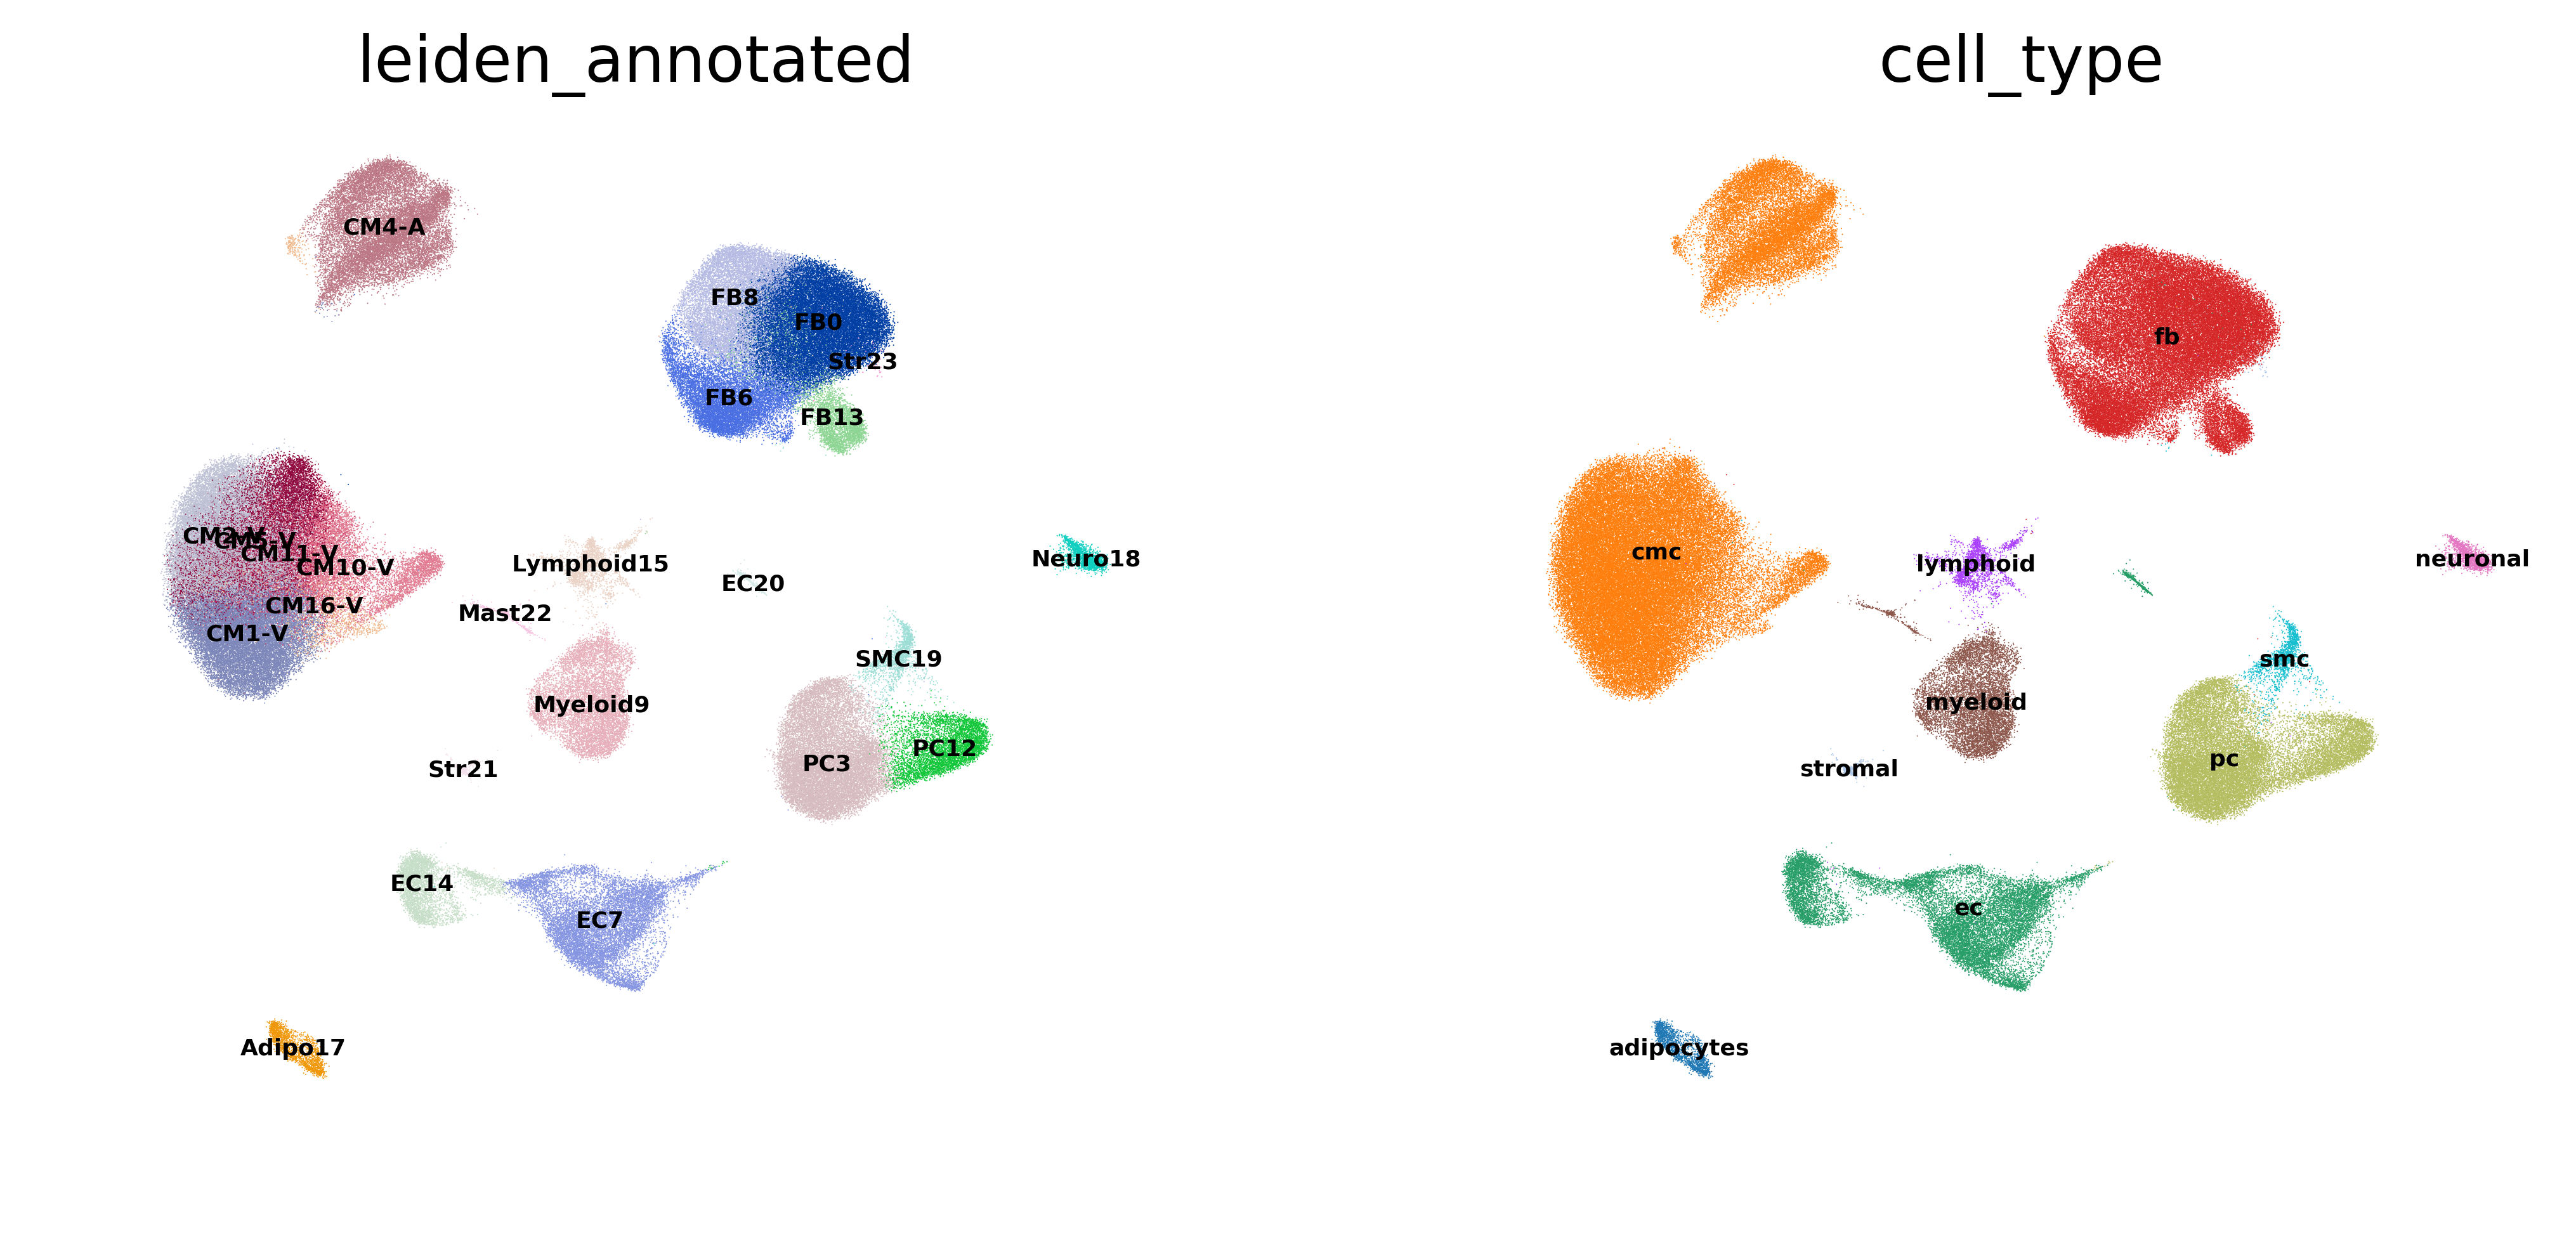

In [17]:
sc.pl.umap(sanger_nuclei_raw, color=['leiden_annotated','cell_type'], size = 0.3, legend_fontsize = 5, legend_loc = 'on data', frameon = False)

In [18]:
sanger_cd45_raw.obs['leiden_annotated'].cat.categories

Index(['EC0', 'PC1', 'EC2', 'EC3', 'Myeloid4', 'SMC5', 'Myeloid6', 'Lymphoid7',
       'Lymphoid8', 'EC9', 'FB10', 'Lymphoid11', 'CMC-V12', 'CMC-A13',
       'Neuronal14'],
      dtype='object')

In [19]:
trans_from = [['CMC-V12','CMC-A13'],['EC0','EC2', 'EC3','EC9'],['PC1'],['SMC5'],['FB10'],['Lymphoid7','Lymphoid8','Lymphoid11'],['Myeloid4','Myeloid6'],['Neuronal14']]
trans_to = ['cmc', 'ec', 'pc', 'smc', 'fb', 'lymphoid', 'myeloid', 'neuronal']

sanger_cd45_raw.obs['cell_type'] = [str(i) for i in sanger_cd45_raw.obs['leiden_annotated']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        sanger_cd45_raw.obs['cell_type'][sanger_cd45_raw.obs['cell_type'] == leiden_from] = celltype

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


... storing 'cell_type' as categorical


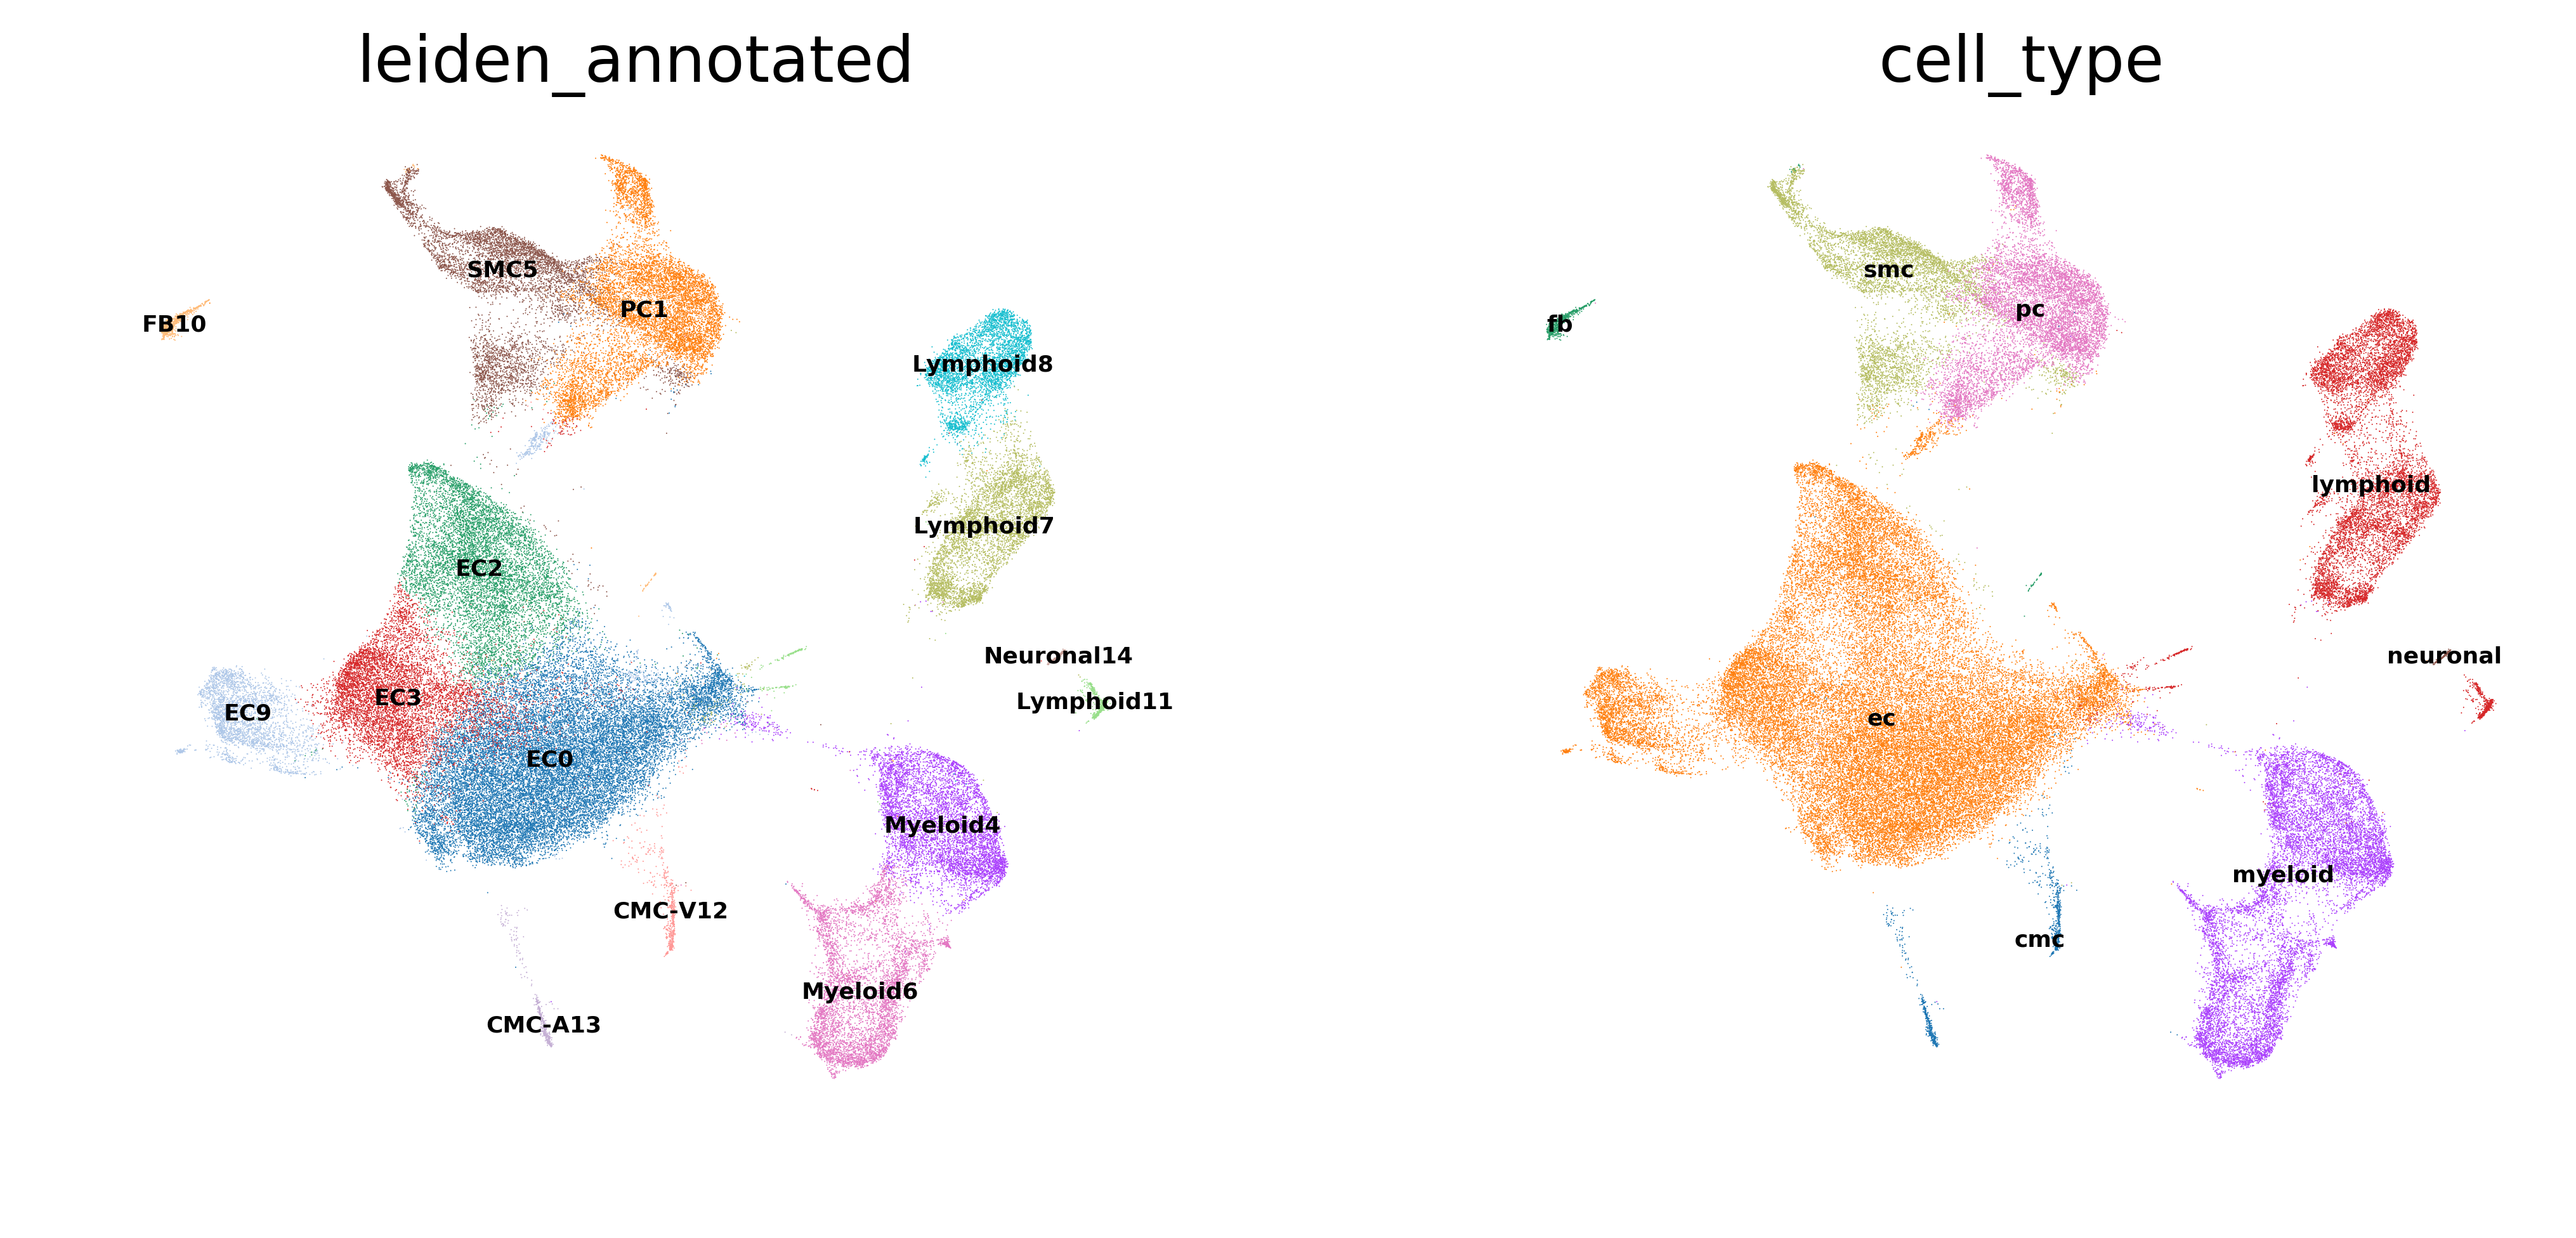

In [20]:
sc.pl.umap(sanger_cd45_raw, color=['leiden_annotated','cell_type'], size = 0.3, legend_fontsize = 5, legend_loc = 'on data', frameon = False)

Now that everything has been successfully renamed, collapse all the data together.

In [21]:
heart_raw = harvard_nuclei_raw.concatenate(sanger_nuclei_raw, sanger_cells_raw, sanger_cd45_raw, batch_key = 'cell_source', batch_categories = ['Harvard-Nuclei', 'Sanger-Nuclei', 'Sanger-Cells', 'Sanger-CD45'], join = 'outer')

In [22]:
heart_raw.X.shape

(499112, 33538)

This is a perfect form for `.raw` - all the genes, "Seurat-normalised" form. So save it as raw.

In [23]:
heart_raw.raw = heart_raw.copy()

In [24]:
heart_raw.write('/home/jovyan/experiments/1-scGEN_data_integration/heart_sanvard_scGen_celltypes_ctl191209_RAW.h5ad')

... storing 'NRP' as categorical
... storing 'age_group' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'donor' as categorical
... storing 'leiden' as categorical
... storing 'leiden_annotated' as categorical
... storing 'region' as categorical
... storing 'sample' as categorical
... storing 'source' as categorical
... storing 'type' as categorical
... storing 'version' as categorical
... storing 'feature_types-Harvard-Nuclei' as categorical
... storing 'feature_types-Sanger-Nuclei' as categorical
... storing 'feature_types-Sanger-Cells' as categorical
... storing 'feature_types-Sanger-CD45' as categorical
... storing 'feature_types-Harvard-Nuclei' as categorical
... storing 'feature_types-Sanger-Nuclei' as categorical
... storing 'feature_types-Sanger-Cells' as categorical
... storing 'feature_types-Sanger-CD45' as categorical
